In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import joblib
import time

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(" Libraries imported successfully!")
print(f" XGBoost version: {xgb.__version__}")

 Libraries imported successfully!
 XGBoost version: 2.0.3


### 1. Load Processed Data

In [2]:
train_processed = pd.read_csv('../data/processed/train_processed.csv')

print("Data Loading")
print("=" * 80)
print(f"\n Dataset shape: {train_processed.shape}")
print(f" Number of features: {train_processed.shape[1] - 2}")
print(f" Target variable: RUL (Remaining Useful Life)")

print("\n First few rows:")
display(train_processed.head())

Data Loading

 Dataset shape: (20631, 113)
 Number of features: 111
 Target variable: RUL (Remaining Useful Life)

 First few rows:


,unit_id,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_9,...,sensor_2_lag_5,sensor_3_lag_1,sensor_3_lag_2,sensor_3_lag_5,sensor_4_lag_1,sensor_4_lag_2,sensor_4_lag_5,stage_early,stage_mid,stage_late
0,1,-1.565170,-0.315980,-1.372953,0.0,-1.721725,-0.134255,-0.925936,1.121141,-0.862813,...,-1.737067,-0.122526,-0.110816,-0.074472,-0.922252,-0.917567,-0.903493,True,False,False
1,1,-1.550652,0.872722,-1.031720,0.0,-1.061780,0.211528,-0.643726,0.431930,-0.958818,...,-1.737067,-0.122526,-0.110816,-0.074472,-0.922252,-0.917567,-0.903493,True,False,False
2,1,-1.536134,-1.961874,1.015677,0.0,-0.661813,-0.413166,-0.525953,1.008155,-0.557139,...,-1.737067,0.226063,-0.110816,-0.074472,-0.636438,-0.917567,-0.903493,True,False,False
3,1,-1.521616,0.324090,-0.008022,0.0,-0.661813,-1.261314,-0.784831,1.222827,-0.713826,...,-1.737067,-0.403700,0.240492,-0.074472,-0.517161,-0.628663,-0.903493,True,False,False
4,1,-1.507098,-0.864611,-0.690488,0.0,-0.621816,-1.251528,-0.301518,0.714393,-0.457059,...,-1.737067,-1.258731,-0.394183,-0.074472,-0.779345,-0.508097,-0.903493,True,False,False


### 2. Prepare Data for Modeling

#### Train test Split Strategy
 - In time-series we can't use random split
 - Split by engine ID (no data leakage)

In [3]:
print("Data Preparation")

print(f"Rows before dropna: {len(train_processed)}")
train_processed = train_processed.dropna().reset_index(drop=True)
print(f"Rows after dropna: {len(train_processed)}")

feature_cols = [col for col in train_processed.columns if col not in ['unit_id', 'RUL']]
X = train_processed[feature_cols]
y = train_processed['RUL']
unit_ids = train_processed['unit_id']

print(f"\n Feature matrix shape: {X.shape}")
print(f" Target vector shape: {y.shape}")

unique_engines = train_processed['unit_id'].unique()
n_train_engines = int(len(unique_engines) * 0.8)

train_engines = unique_engines[:n_train_engines]
test_engines = unique_engines[n_train_engines:]

train_mask = train_processed['unit_id'].isin(train_engines)
test_mask = train_processed['unit_id'].isin(test_engines)

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"\n Train-Test Split Complete:")
print(f"   - Training engines: {len(train_engines)} ({len(X_train)} samples)")
print(f"   - Testing engines: {len(test_engines)} ({len(X_test)} samples)")
print(f"   - Split ratio: {len(X_train) / len(X) * 100:.1f}% train / {len(X_test) / len(X) * 100:.1f}% test")

overlap = set(train_engines) & set(test_engines)
print(f"\n Data leakage check: {' FAILED' if overlap else ' PASSED'}")
if overlap:
    print(f"   Overlapping engines: {overlap}")

Data Preparation
Rows before dropna: 20631
Rows after dropna: 20531

 Feature matrix shape: (20531, 111)
 Target vector shape: (20531,)

 Train-Test Split Complete:
   - Training engines: 80 (16058 samples)
   - Testing engines: 20 (4473 samples)
   - Split ratio: 78.2% train / 21.8% test

 Data leakage check:  PASSED


### Define Evaluation Matrix

Calculate all evaluation metrics for a model.
    
    Key Concepts:
    - Underestimated RUL (y_pred < y_true): Model predicts failure SOONER -> Early maintenance (SAFE)
    - Overestimated RUL (y_pred > y_true): Model predicts failure LATER -> Late maintenance (DANGEROUS)

In [4]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    errors = y_pred - y_true
    underestimated_rul = errors < 0 
    overestimated_rul = errors > 0 

    overestimation_penalty = np.sum(np.abs(errors[overestimated_rul]) * 2)
    underestimation_penalty = np.sum(np.abs(errors[underestimated_rul]))
    asymmetric_score = (overestimation_penalty + underestimation_penalty) / len(y_true)
    
    results = {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'asymmetric_score': asymmetric_score,
        'overestimated_pct': (overestimated_rul.sum() / len(y_true)) * 100,
        'underestimated_pct': (underestimated_rul.sum() / len(y_true)) * 100
    }
    
    return results

def print_results(results):
    print(f"{results['model'].upper()} PERFORMANCE")
    print(f"\n Standard Metrics:")
    print(f"   - RMSE: {results['rmse']:.2f} cycles")
    print(f"   - MAE:  {results['mae']:.2f} cycles")
    print(f"   - R²:   {results['r2']:.4f}")
    print(f"\n Business Metrics:")
    print(f"   - Asymmetric Score: {results['asymmetric_score']:.2f}")
    print(f"     (Penalizes overestimation 2x more than underestimation)")
    
    print(f"\n Prediction Breakdown:")
    print(f"    Underestimated RUL (Safe):     {results['underestimated_pct']:.1f}%")
    print(f"      -> Predicts failure sooner -> Early maintenance")
    print(f"    Overestimated RUL (Risky):    {results['overestimated_pct']:.1f}%")
    print(f"      -> Predicts failure later -> Potential missed failures")
    print(f"\n Interpretation:")
    if results['rmse'] < 15:
        print(f"    Excellent: Very accurate predictions!")
    elif results['rmse'] < 25:
        print(f"    Good: Acceptable for production")
    else:
        print(f"    Needs improvement")
    
    if results['late_predictions_pct'] < 30:
        print(f"    Low risk: Few dangerous late predictions")
    else:
        print(f"    High risk: Many late predictions")

print(" Evaluation functions defined!")

 Evaluation functions defined!


### 4. Model 1: Baseline - Linear Regression

In [5]:
print("Model 1: Linear Regression (Baseline)")
start_time = time.time()
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
training_time = time.time() - start_time

y_pred_lr = lr_model.predict(X_test)

lr_results = evaluate_model(y_test, y_pred_lr, "Linear Regression")
lr_results['training_time'] = training_time

print(lr_results)
print(f"\n Training time: {training_time:.3f} seconds")

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': np.abs(lr_model.coef_)
}).sort_values('coefficient', ascending=False)

print(f"\n Top 10 Most Important Features:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"   {row['feature']:50s} {row['coefficient']:8.4f}")

Model 1: Linear Regression (Baseline)
{'model': 'Linear Regression', 'rmse': 6.810508410909662, 'mae': 5.406917531938594, 'r2': 0.972814630974583, 'asymmetric_score': 8.236884843948674, 'overestimated_pct': 57.70176615247038, 'underestimated_pct': 42.29823384752962, 'training_time': 0.1416308879852295}

 Training time: 0.142 seconds

 Top 10 Most Important Features:
   sensor_3                                           313062004198.0842
   sensor_3_lag_1                                     310541949290.8635
   sensor_3_rate_of_change                            288178428957.0363
   op_setting_3                                       208524029457.8590
   stage_mid                                          173524565553.4612
   stage_late                                         173524565548.0089
   stage_early                                        173524565547.5509
   sensor_2_rolling_mean_5                            113528817439.5237
   sensor_4_cumsum                                    1

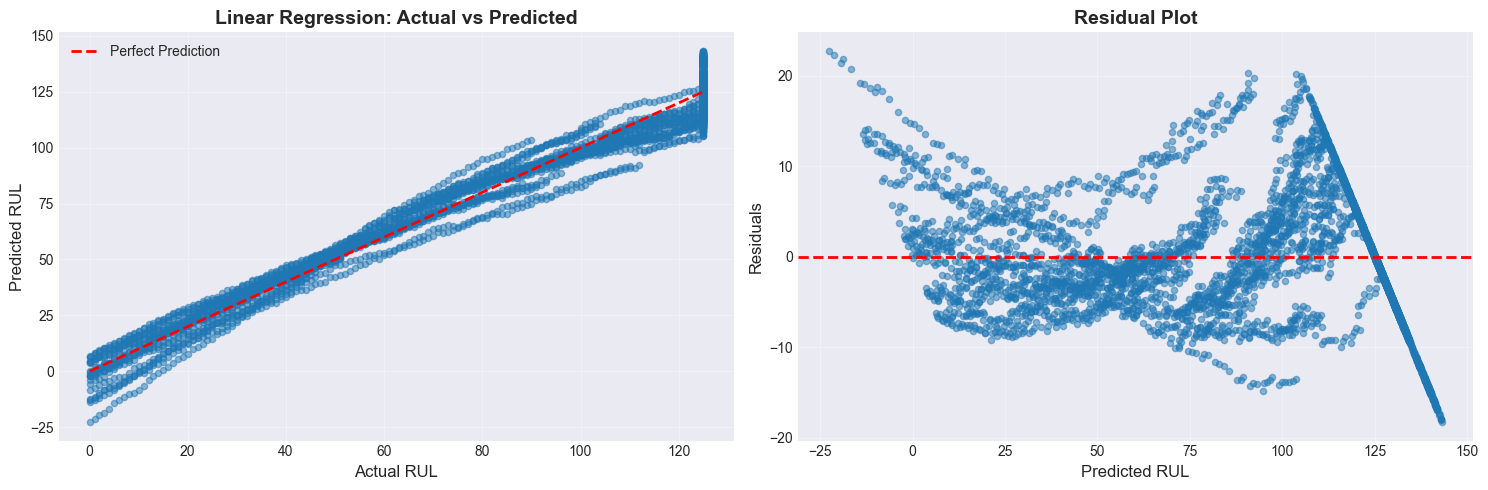


 What to look for:
   - Left plot: Points should be on red line (perfect predictions)
   - Right plot: Residuals should be randomly scattered around 0
   - Patterns in residuals indicate model can be improved


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(y_test, y_pred_lr, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual RUL', fontsize=12)
axes[0].set_ylabel('Predicted RUL', fontsize=12)
axes[0].set_title('Linear Regression: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

residuals = y_test - y_pred_lr
axes[1].scatter(y_pred_lr, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted RUL', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n What to look for:")
print("   - Left plot: Points should be on red line (perfect predictions)")
print("   - Right plot: Residuals should be randomly scattered around 0")
print("   - Patterns in residuals indicate model can be improved")

### 5. Model 2: Random Forest

In [7]:
print("Model 2: Random Forest")

print("\n Training Random Forest...")
start_time = time.time()

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

y_pred_rf = rf_model.predict(X_test)

rf_results = evaluate_model(y_test, y_pred_rf, "Random Forest")
rf_results['training_time'] = training_time

print(rf_results)
print(f"\n Training time: {training_time:.2f} seconds")

feature_importance_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n Top 10 Most Important Features:")
for idx, row in feature_importance_rf.head(10).iterrows():
    print(f"   {row['feature']:50s} {row['importance']:8.4f}")

Model 2: Random Forest

 Training Random Forest...
{'model': 'Random Forest', 'rmse': 5.708626008786092, 'mae': 3.9684532112473025, 'r2': 0.9808997369183396, 'asymmetric_score': 5.123917686687045, 'overestimated_pct': 27.96780684104628, 'underestimated_pct': 71.45092778895595, 'training_time': 4.777269124984741}

 Training time: 4.78 seconds

 Top 10 Most Important Features:
   cycles_remaining                                     0.1922
   cycle_ratio                                          0.1175
   stage_late                                           0.0783
   sensor_2_rolling_mean_10                             0.0770
   sensor_4_rolling_mean_10                             0.0537
   sensor_2_rolling_mean_20                             0.0498
   sensor_3_rolling_mean_10                             0.0344
   time_cycles                                          0.0313
   sensor_4_rolling_mean_20                             0.0293
   sensor_3_rolling_mean_20                            

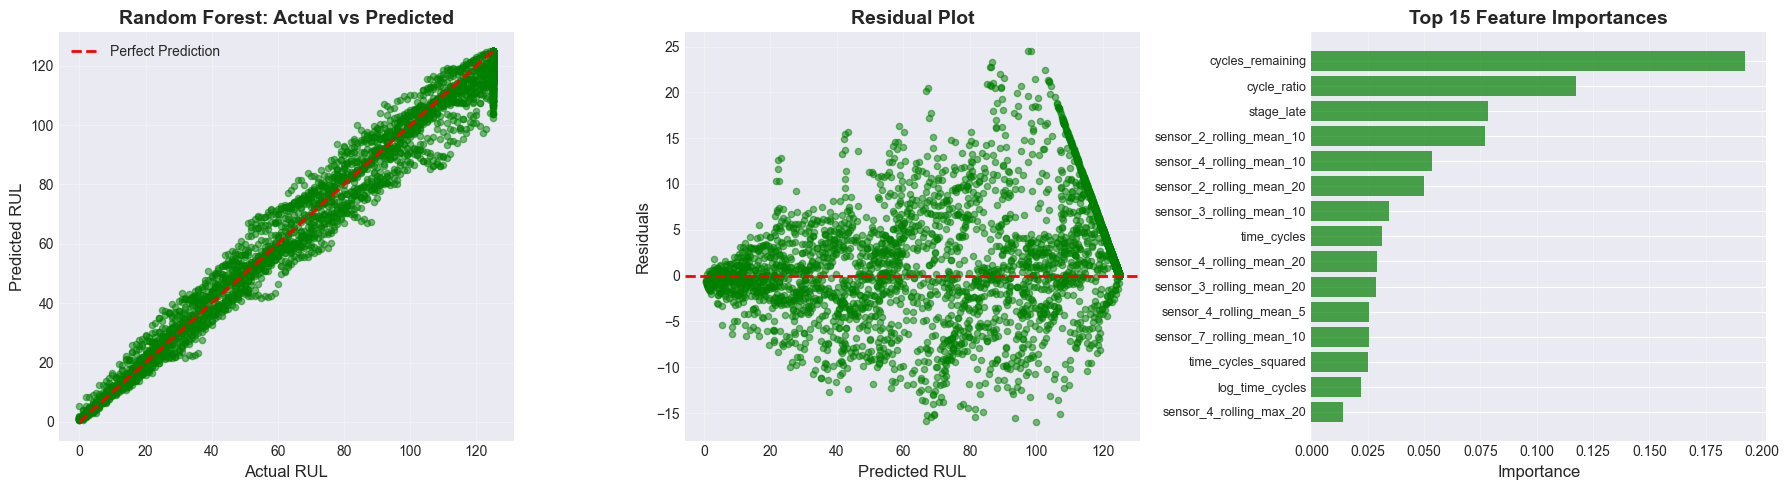

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(y_test, y_pred_rf, alpha=0.5, s=20, c='green')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual RUL', fontsize=12)
axes[0].set_ylabel('Predicted RUL', fontsize=12)
axes[0].set_title('Random Forest: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

residuals_rf = y_test - y_pred_rf
axes[1].scatter(y_pred_rf, residuals_rf, alpha=0.5, s=20, c='green')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted RUL', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

top_features = feature_importance_rf.head(15)
axes[2].barh(range(len(top_features)), top_features['importance'], color='green', alpha=0.7)
axes[2].set_yticks(range(len(top_features)))
axes[2].set_yticklabels([f[:30] for f in top_features['feature']], fontsize=9)
axes[2].set_xlabel('Importance', fontsize=12)
axes[2].set_title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
axes[2].invert_yaxis()
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### 6. Model 3: XGBoost (Gradient Bossting)

In [9]:
print("Model 3: XGBoost (Gradient Boosting)")

train_units = train_processed.loc[X_train.index, "unit_id"]

unique_units = train_units.unique()
n_val_units = max(1, int(len(unique_units) * 0.2))

val_units = unique_units[-n_val_units:]
train_units_set = set(unique_units[:-n_val_units])

train_mask_xgb = train_units.isin(train_units_set)
val_mask_xgb = train_units.isin(val_units)

X_train_xgb = X_train.loc[train_mask_xgb]
y_train_xgb = y_train.loc[train_mask_xgb]
X_val = X_train.loc[val_mask_xgb]
y_val = y_train.loc[val_mask_xgb]

print(f"\n Data split (engine-wise):")
print(f"   - Training:   {len(X_train_xgb)} samples ({train_units[train_mask_xgb].nunique()} engines)")
print(f"   - Validation: {len(X_val)} samples ({train_units[val_mask_xgb].nunique()} engines)")
print(f"   - Test:       {len(X_test)} samples")

print("\n Training XGBoost...")
start_time = time.time()

xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

xgb_model.fit(
    X_train_xgb, y_train_xgb,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=50,
    verbose=False
)

training_time = time.time() - start_time
best_iteration = xgb_model.best_iteration

print(f"\n Training complete!")
print(f"   - Best iteration: {best_iteration}")
print(f"   - Stopped early: {best_iteration < 1000}")

y_pred_xgb = xgb_model.predict(X_test)

xgb_results = evaluate_model(y_test, y_pred_xgb, "XGBoost")
xgb_results['training_time'] = training_time
xgb_results['best_iteration'] = best_iteration

print(xgb_results)
print(f"\n Training time: {training_time:.2f} seconds")

feature_importance_xgb = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n Top 10 Most Important Features:")
for idx, row in feature_importance_xgb.head(10).iterrows():
    print(f"   {row['feature']:50s} {row['importance']:8.4f}")

Model 3: XGBoost (Gradient Boosting)

 Data split (engine-wise):
   - Training:   12700 samples (64 engines)
   - Validation: 3358 samples (16 engines)
   - Test:       4473 samples

 Training XGBoost...

 Training complete!
   - Best iteration: 999
   - Stopped early: True
{'model': 'XGBoost', 'rmse': 0.9283866756450984, 'mae': 0.42375410056683194, 'r2': 0.9994948341743424, 'asymmetric_score': 0.5047957011145179, 'overestimated_pct': 36.999776436396154, 'underestimated_pct': 63.00022356360384, 'training_time': 19.613115549087524, 'best_iteration': 999}

 Training time: 19.61 seconds

 Top 10 Most Important Features:
   stage_late                                           0.6234
   cycles_remaining                                     0.1861
   cycle_ratio                                          0.0860
   sensor_3_rolling_mean_20                             0.0244
   stage_early                                          0.0209
   sensor_4_rolling_mean_5                              0.02

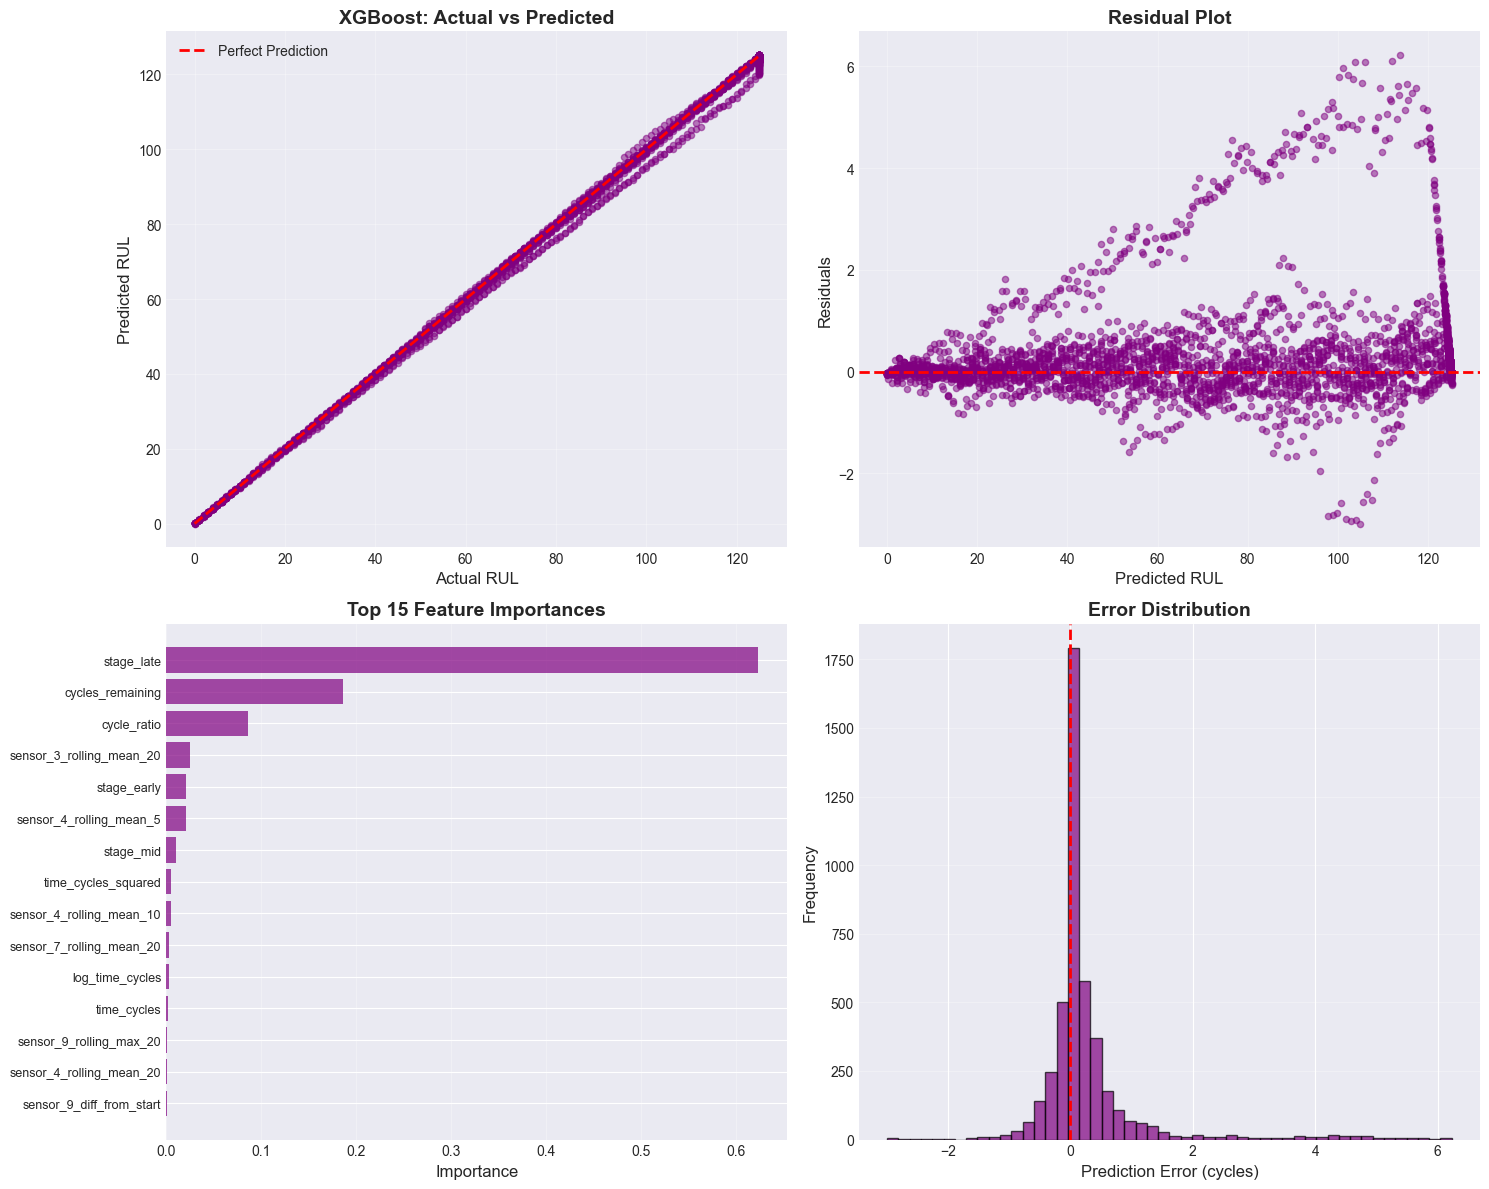


 Key Observations:
   - Mean error: 0.26 cycles
   - Std of errors: 0.89 cycles
   - 95% of errors within: ±1.75 cycles


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].scatter(y_test, y_pred_xgb, alpha=0.5, s=20, c='purple')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual RUL', fontsize=12)
axes[0, 0].set_ylabel('Predicted RUL', fontsize=12)
axes[0, 0].set_title('XGBoost: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

residuals_xgb = y_test - y_pred_xgb
axes[0, 1].scatter(y_pred_xgb, residuals_xgb, alpha=0.5, s=20, c='purple')
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted RUL', fontsize=12)
axes[0, 1].set_ylabel('Residuals', fontsize=12)
axes[0, 1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

top_features_xgb = feature_importance_xgb.head(15)
axes[1, 0].barh(range(len(top_features_xgb)), top_features_xgb['importance'], 
                color='purple', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_features_xgb)))
axes[1, 0].set_yticklabels([f[:30] for f in top_features_xgb['feature']], fontsize=9)
axes[1, 0].set_xlabel('Importance', fontsize=12)
axes[1, 0].set_title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

axes[1, 1].hist(residuals_xgb, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Prediction Error (cycles)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Error Distribution', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n Key Observations:")
print(f"   - Mean error: {residuals_xgb.mean():.2f} cycles")
print(f"   - Std of errors: {residuals_xgb.std():.2f} cycles")
print(f"   - 95% of errors within: ±{residuals_xgb.std() * 1.96:.2f} cycles")

### 7. Hyperparameter Tuning (XGBoost)

In [13]:
# from sklearn.model_selection import GroupKFold, GridSearchCV
# from sklearn.metrics import make_scorer, mean_squared_error
# import numpy as np
# import xgboost as xgb

# # Groups = engine ids for each row in X_train
# groups = train_processed.loc[X_train.index, "unit_id"]

# # Base model (fixed params)
# xgb_base = xgb.XGBRegressor(
#     n_estimators=800,            # keep moderate for grid search speed
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_lambda=1.0,
#     random_state=42,
#     n_jobs=-1,
#     objective="reg:squarederror",
#     verbosity=0
# )

# param_grid = {
#     "learning_rate": [0.01, 0.05, 0.1],
#     "max_depth": [5, 7, 9],
#     "min_child_weight": [1, 3, 5],
#     "gamma": [0, 0.1, 0.2]
# }

# # RMSE scorer (GridSearchCV maximizes score, so we return negative RMSE)
# def neg_rmse(y_true, y_pred):
#     return -np.sqrt(mean_squared_error(y_true, y_pred))

# rmse_scorer = make_scorer(neg_rmse, greater_is_better=True)

# gkf = GroupKFold(n_splits=3)

# grid_search = GridSearchCV(
#     estimator=xgb_base,
#     param_grid=param_grid,
#     scoring=rmse_scorer,
#     cv=gkf.split(X_train, y_train, groups=groups),  # ✅ group-aware CV
#     verbose=2,
#     n_jobs=-1
# )

# print("🚀 Starting GroupKFold Grid Search...")
# grid_search.fit(X_train, y_train)

# print("\n✅ Grid Search Complete!")
# print("🏆 Best Params:", grid_search.best_params_)
# print(f"📉 Best CV RMSE: {-grid_search.best_score_:.3f}")

# # Train best model on FULL training set and test once on X_test
# best_model = grid_search.best_estimator_
# y_pred_best = best_model.predict(X_test)

# best_results = evaluate_model(y_test, y_pred_best, "XGBoost (GroupKFold Tuned)")
# print(best_results)


### 8. Model Comparison

In [14]:
all_results = pd.DataFrame([lr_results, rf_results, xgb_results])

print("Model Comparison Summary")

display(all_results[['model', 'rmse', 'mae', 'r2', 'asymmetric_score', 
                     'overestimated_pct', 'underestimated_pct', 'training_time']])

best_model_idx = all_results['rmse'].idxmin()
best_model_name = all_results.loc[best_model_idx, 'model']

print(f"\n Winner: {best_model_name}")
print(f"\n Performance Summary:")
print(f"   - Best RMSE: {all_results['rmse'].min():.2f} cycles")
print(f"   - Improvement over baseline: {((lr_results['rmse'] - all_results['rmse'].min()) / lr_results['rmse'] * 100):.1f}%")
print(f"   - Risky predictions (overestimated): {all_results.loc[best_model_idx, 'overestimated_pct']:.1f}%")
print(f"   - Safe predictions (underestimated): {all_results.loc[best_model_idx, 'underestimated_pct']:.1f}%")

Model Comparison Summary


,model,rmse,mae,r2,asymmetric_score,overestimated_pct,underestimated_pct,training_time
0,Linear Regression,6.810508,5.406918,0.972815,8.236885,57.701766,42.298234,0.141631
1,Random Forest,5.708626,3.968453,0.980900,5.123918,27.967807,71.450928,4.777269
2,XGBoost,0.928387,0.423754,0.999495,0.504796,36.999776,63.000224,19.613116



 Winner: XGBoost

 Performance Summary:
   - Best RMSE: 0.93 cycles
   - Improvement over baseline: 86.4%
   - Risky predictions (overestimated): 37.0%
   - Safe predictions (underestimated): 63.0%


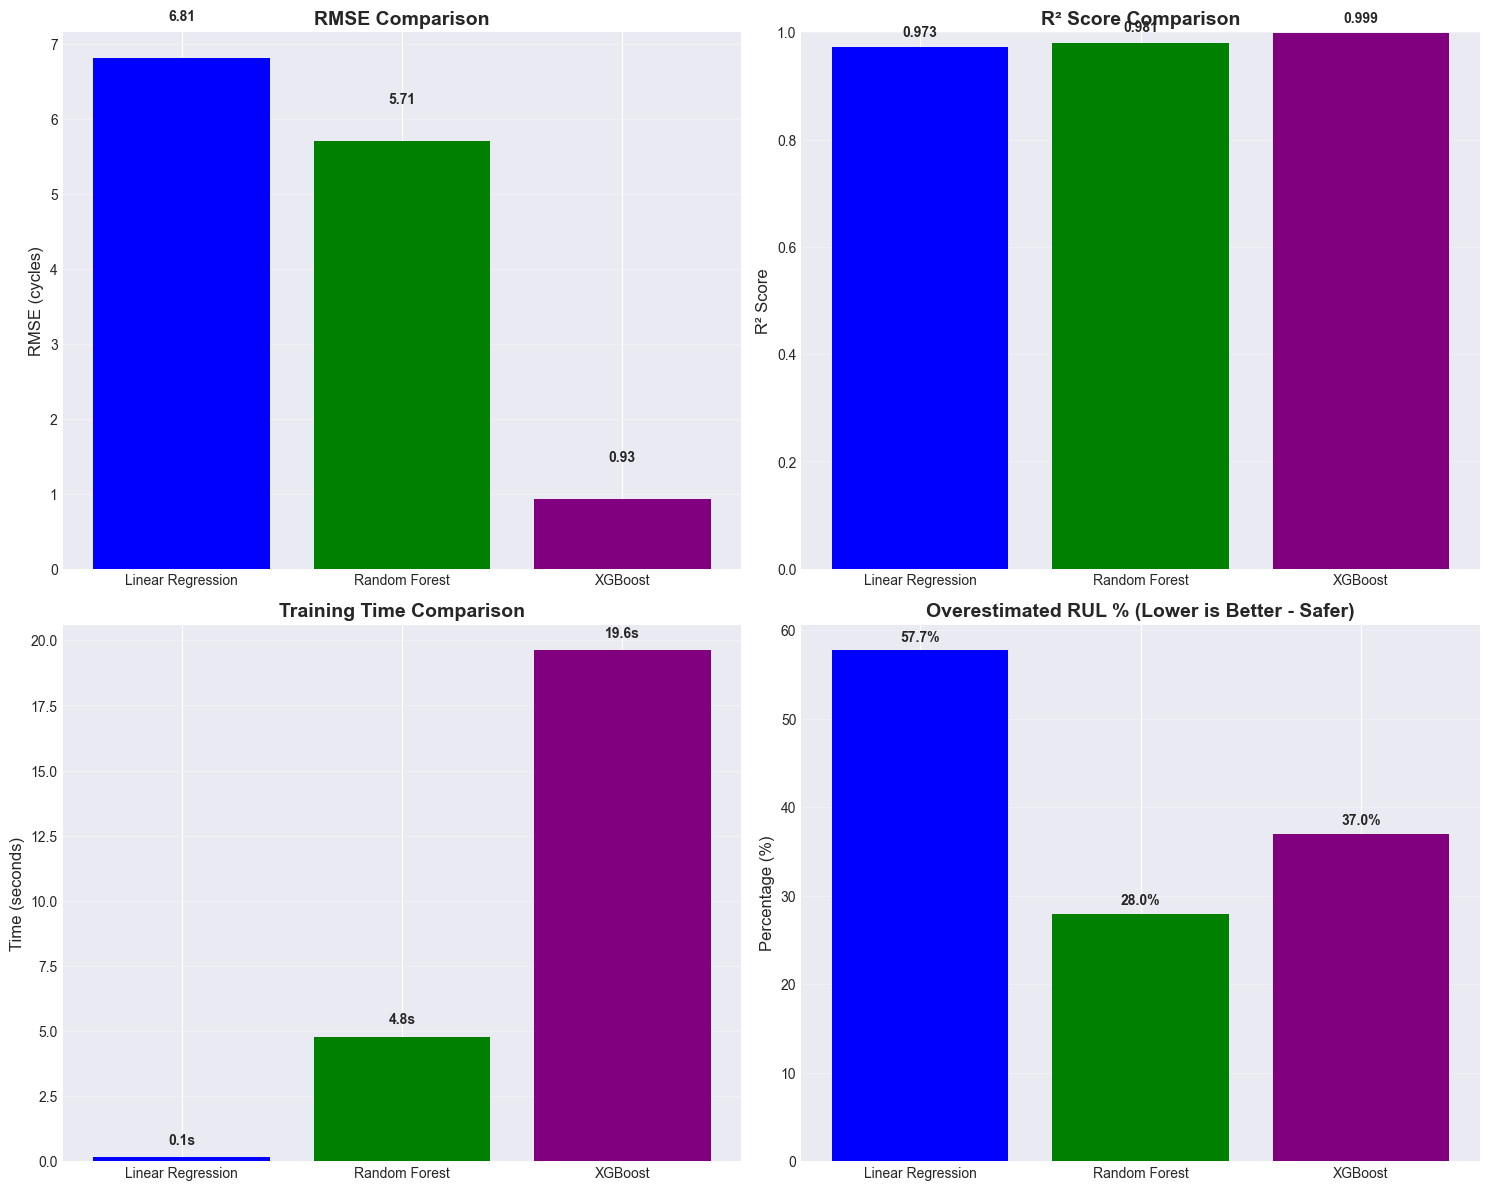

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].bar(all_results['model'], all_results['rmse'], color=['blue', 'green', 'purple'])
axes[0, 0].set_ylabel('RMSE (cycles)', fontsize=12)
axes[0, 0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(all_results['rmse']):
    axes[0, 0].text(i, v + 0.5, f"{v:.2f}", ha='center', fontweight='bold')

axes[0, 1].bar(all_results['model'], all_results['r2'], color=['blue', 'green', 'purple'])
axes[0, 1].set_ylabel('R² Score', fontsize=12)
axes[0, 1].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(all_results['r2']):
    axes[0, 1].text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')

axes[1, 0].bar(all_results['model'], all_results['training_time'], color=['blue', 'green', 'purple'])
axes[1, 0].set_ylabel('Time (seconds)', fontsize=12)
axes[1, 0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(all_results['training_time']):
    axes[1, 0].text(i, v + 0.5, f"{v:.1f}s", ha='center', fontweight='bold')

axes[1, 1].bar(all_results['model'], all_results['overestimated_pct'], color=['blue', 'green', 'purple'])
axes[1, 1].set_ylabel('Percentage (%)', fontsize=12)
axes[1, 1].set_title('Overestimated RUL % (Lower is Better - Safer)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(all_results['overestimated_pct']):
    axes[1, 1].text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### Save Best Model

In [16]:
import os

os.makedirs('../models/saved_models', exist_ok=True)

joblib.dump(xgb_model, '../models/saved_models/xgboost_model.pkl')
print(" Saved: xgboost_model.pkl")

joblib.dump(rf_model, '../models/saved_models/random_forest_model.pkl')
print(" Saved: random_forest_model.pkl")

scaler = joblib.load('../data/processed/scaler.pkl')
joblib.dump(scaler, '../models/saved_models/scaler.pkl')
print(" Saved: scaler.pkl")

joblib.dump(feature_cols, '../models/saved_models/feature_columns.pkl')
print(" Saved: feature_columns.pkl")

all_results.to_csv('../models/saved_models/model_comparison.csv', index=False)
print(" Saved: model_comparison.csv")

print("\n All models and artifacts saved successfully!")
print("\n Saved files:")
print("   - XGBoost model (for deployment)")
print("   - Random Forest model (for comparison)")
print("   - Scaler (for preprocessing new data)")
print("   - Feature columns (for consistency)")
print("   - Model comparison results")

 Saved: xgboost_model.pkl
 Saved: random_forest_model.pkl
 Saved: scaler.pkl
 Saved: feature_columns.pkl
 Saved: model_comparison.csv

 All models and artifacts saved successfully!

 Saved files:
   - XGBoost model (for deployment)
   - Random Forest model (for comparison)
   - Scaler (for preprocessing new data)
   - Feature columns (for consistency)
   - Model comparison results
